<a href="https://colab.research.google.com/github/otoperalias/Coyuntura/blob/main/clases/Tema3_IV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tema 3.2. Introducción a la modelización de series. Modelos ARIMA.

In [8]:
# Instalamos la librería pmdarima (la vamos a necesitar en esta sesión)
!pip install pmdarima --user # Si usamos Jupyter, quitamos el signo de exclamación

In [2]:
# Importamos funciones y establecemos configuración general
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('Solarize_Light2')
plt.rcParams["figure.figsize"] = [10,4]  # Default figure size

# PATH
path="C:/Users/danie/Dropbox/CyP/T3/"

In [ ]:
# Importamos datos
df = pd.read_excel("https://raw.githubusercontent.com/otoperalias/Coyuntura/main/clases/datos/ventas.xlsx", index_col=0, parse_dates=True)
df.ventas=df.ventas.astype('float32') 
df

## MODELIZACIÓN DE SERIES.

### 1. Visualización

In [ ]:
# Gráfico serie original
df.plot.line(figsize=(12,6))
plt.title('Ventas 1990 - 1998')
plt.show()

In [ ]:
# Gráfico medias móviles
rol_mean=df.rolling(window=12).mean()
rol_std = df.rolling(window=12).std()

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df, color='blue',label='Original')
ax.plot(rol_mean, color='red', label='Rolling Mean')
ax.plot(rol_std, color='black', label = 'Rolling Std')
ax.legend(loc='best')
ax.set_title('Rolling Mean & Standard Deviation')
plt.show()

In [ ]:
#Correlogramas
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, figsize=(12,6))
plot_acf(df.dropna(), ax=ax[0], lags=20)
plot_pacf(df.dropna(), ax=ax[1], lags=20)
plt.show()

### 2. Unit Root Tests

In [ ]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller
def DFtest(datos):
    print('Results of Dickey-Fuller Test (H0= NO estac.):')
    dftest = adfuller(datos, autolag='AIC')
    print('Test Statistic', dftest[0])
    print('p-value', dftest[1])
    print('#Lags Used', dftest[2])
    print('# obs', dftest[3])      
    for k, v in dftest[4].items():
        print(k,v)
DFtest(df.ventas)

In [ ]:
# KPSS
from statsmodels.tsa.stattools import kpss
def KPSStest(datos):
    print('Results of KPSS Test (H0= Estac.):')
    dftest = kpss((datos), 'ct')
    print("Test statistic = ", dftest[0])
    print("P-value = ", dftest[1])
    print("Critical values :")
    for k, v in dftest[3].items():
        print(k,v)
KPSStest(df.ventas) 


### 3. Estacionarizar

In [ ]:
# Es  útil dibujar un gráfico como este, que combine varias transformaciones en una representación
fig, ax = plt.subplots(3, 2, figsize=(10,10))
# Serie original
ax[0,0].plot(df.ventas)
ax[0,0].set_title('Serie original')
plot_acf(df.ventas, ax=ax[0, 1])
# Primera diferencia
ax[1,0].plot(df.ventas.diff())
ax[1,0].set_title('Primera diferencia')
plot_acf(df.ventas.diff().dropna(), ax=ax[1, 1])
# Segunda diferencia
ax[2,0].plot(df.ventas.diff().diff())
ax[2,0].set_title('Segundas diferencias')
plot_acf(df.ventas.diff().diff().dropna(), ax=ax[2, 1])
plt.subplots_adjust(hspace=0.3)
plt.show()

Para estacionarizar, parece conveniente empezar tomando simplemente primeras diferencias ya que los coeficientes de correlación caen rápidamente. Al tomar diferencias de segundo orden, vemos que el segundo retardo tiene un coeficiente negativo elevado, indicando que la serie podría estar sobre-diferenciada (over differencied).

In [ ]:
# Podemos también comprobar que tomando logaritmos no se mejoran los resultados:

plt.plot(np.log(df.ventas).diff())
plot_acf(np.log(df.ventas).diff().dropna())

Comprobamos si la serie es estacionaria con el DFtest:

In [ ]:
#Comprobamos si la serie es estacionaria con el DFtest
DFtest(df.ventas.diff().dropna())  
KPSStest(df.ventas.diff().dropna())  

Los resultados de los tests nos muestran que está en el límite: estacionariedad débil.  
Por tanto, con las reservas mencionadas, fijamos el orden de diferenciación en uno => d=1.

### 4. Dibujar correlogramas para identificar los parámetros p y q (AR y MA)

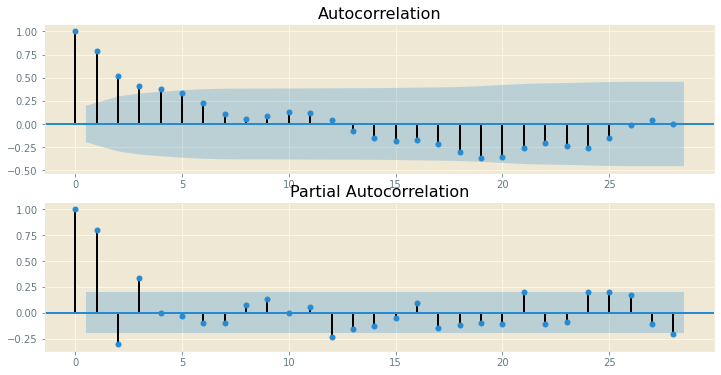

In [ ]:
fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(df.ventas.diff().dropna(), ax=ax[0], lags=28)
ax[1] = plot_pacf(df.ventas.diff().dropna(), ax=ax[1], lags=28)

* Componente MA: Vemos en ACF que hay dos retardos bien por encima del nivel de significancia=> q=2.
* Componente AR: El primer retardo el PACF es muy significativo y luego se reduce bastante. Al principio
podemos ser conservadores y establecer p=1.


### 5. Construir el modelo ARIMA

In [14]:
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
# 1,1,2 ARIMA Model (p,d,q=1,1,2)
model = ARIMA(df.ventas, order=(1,1,2))
model_fit = model.fit()
print(model_fit.summary())

Observamos que el coeficiente MA.2 es muy cercano a cero y muy insignificante estadísticamente, por tanto, probamos ahora con ARIMA(1,1,1)

In [ ]:
# 1,1,1 ARIMA Model
model_fit = ARIMA(df.ventas, order=(1,1,1)).fit()
print(model_fit.summary())

* AIC es menor, lo cual es bueno.
* Todos los coeficientes son altamente significativos :)
* Ahora representamos los residuos para asegurarnos de que no hay patrones en ellos (o sea, media y varianza constantes)

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(2,2,figsize=(12,5))
residuals.plot(title="Residuos", ax=ax[0,0])
residuals.plot(kind='kde', title='Density', ax=ax[1,0])
plot_acf(residuals, ax=ax[0,1], lags=28)
plot_pacf(residuals, ax=ax[1,1], lags=28)
plt.subplots_adjust(hspace=0.5)
plt.show()

Los residuios parecen correctos con media casi cero y varianza uniforme.


## PREDICCIÓN

### 1. Buscando el modelo óptimo: out-of-sample validation

In [5]:
# 1. Creamos training y test datasets
train = df.ventas[:85]
test = df.ventas[85:] # 15% de la base de datos

In [ ]:
# 2. Construimos el modelo ARIMA(1,1,1)
model_fit = ARIMA(train, order=(1, 1, 1)).fit()

In [ ]:
# 3. Predecimos
fc,se,conf=model_fit.forecast(15, alpha=0.05)  # (out of sample forecasts , 95% conf)

In [ ]:
# 4. Convertimos en series de Pandas
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)  # IC inferior [todas filas, primer columna] del array conf
upper_series = pd.Series(conf[:, 1], index=test.index)  # IC superior [todas filas, segunda columna] del array conf

In [ ]:
# 5. Creamos el gráfico
fig, ax= plt.subplots(figsize=(12,5), dpi=80)
ax.plot(train, label='Training')
ax.plot(test, label='Actual')
ax.plot(fc_series, label='Forecast')
ax.fill_between(lower_series.index, lower_series, upper_series,color='k', alpha=.15)
ax.set_title('Forecast vs Actuals')
ax.legend(loc='upper left', fontsize=12)
plt.show()

* Observamos que el modelo acierta con la dirección de la serie y la predicción entra dentro del int. conf.
* Sin embargo, cada valor predicho es menor que el real, lo cual hace que conforme pasa el tiempo, la predicción y la serie real diverjan.
* Para mejorar el modelo, vamos a probar otras alternativas. Por ej., d=2 e iterativamente incrementar p a 5 y entonces q a 5. 
* Los criterios para evaluar los modelos son a) tener un menor AIC, b) ver gráficamente la predicción y c) comprobar que p-values<0,05.


In [15]:
# Construimos el modelo ARIMA(3,2,1) => tras ir probando, este da buen resultado
model_fit = ARIMA(train, order=(3, 2, 1)).fit()
print(model_fit.summary())

NotImplementedError: ignored

In [ ]:
# Predecimos
fc, se, conf = model_fit.forecast(15, alpha=0.05)
# Creamos pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)
# Dibujamos
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='Training')
plt.plot(test, label='Actual')
plt.plot(fc_series, label='Forecast')
plt.fill_between(lower_series.index, lower_series, upper_series,color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show() 

* AIC más bajo, todo significativo, y la predicción es mejor
* En este caso hemos hecho la predicción al final, pero también se puede hacerla para otros periodos.
* Lo mejor es testar y elegir el mejor modelo en base a diferentes predicciones

#### Medidas para juzgar la bondad o exactitud de la predicción.

In [6]:
def forecast_accuracy(forecast, actual):
    rmse = np.sqrt(np.mean((forecast-actual)**2))
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    return({'rmse':rmse,'mape':mape,'corr':corr})

In [ ]:
forecast_accuracy(fc, test)


Un MAPE de 2.2% indica que el modelo tiene una exactitud del 97.8% prediciendo las 15 observaciones siguientes.

#### Construir el modelo óptimo automáticamente

https://pypi.org/project/pmdarima/
https://www.alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html#pmdarima.arima.auto_arima
Escribir en la consola o editor "pip install pmdarima --user, si no funciona, hacerlo en cmd "pip install pmdarima --user"
pip install pmdarima --user

In [ ]:
import pmdarima as pm

model = pm.auto_arima(train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model.summary())

In [ ]:
# Ahora interpretamos los residuos
model.plot_diagnostics(figsize=(7,5))
plt.subplots_adjust(hspace=0.5)
plt.show()

In [9]:
# Predecimos de nuevo usando este modelo
fc, confint = model.predict(n_periods=15, return_conf_int=True)
index_of_fc = df.index[-15:] # Esto ha cambiado !!
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

In [ ]:
# Gráfico
fig,ax=plt.subplots()
ax.plot(df.ventas) # Esto es nuevo.
ax.plot(fc_series, color='darkgreen')
ax.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
ax.set_title("Predicción Final Ventas")
plt.show()

In [12]:
# Juzgamos la bondad de la predicción
forecast_accuracy(fc, test)

{'corr': 0.9563128635214019,
 'mape': 0.05253766474158482,
 'rmse': 15903.87793380386}

### 2. Predecir "el futuro"